In [179]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import numpy as np
import os
import matplotlib.ticker as mtick 

In [180]:
# 读取数据
raw_structure_data = pd.read_csv('dataset/csv_building_structure.csv', index_col="building_id")

In [181]:
def custom_describe(data:pd.DataFrame):
    # Basic statistics
    desc_stats = data.describe()

    # Missing values count
    missing_values = data.isnull().sum()

    # Unique values count
    unique_values = data.nunique()

    # Identify numeric columns
    numeric_cols = data.select_dtypes(include=['number']).columns

    # Calculate IQR and identify outliers for each numeric column
    outliers = {}
    for col in numeric_cols:
        q1 = desc_stats.loc['25%', col]
        q3 = desc_stats.loc['75%', col]
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers[col] = data[((data[col] < lower_bound) | (data[col] > upper_bound))].shape[0]

    # Get data types for each column
    data_types = data.dtypes
    
    # Combine all information
    custom_description = pd.DataFrame({
        'data_type': data_types,
        'mean': desc_stats.loc['mean'],
        'std': desc_stats.loc['std'],
        'missing_values': missing_values,
        'unique_values': unique_values,
        'outliers': outliers
    })
    
    custom_description.reset_index(inplace=True)
    custom_description.rename(columns={"index":"column_name"},inplace=True)
    return custom_description

In [182]:
# 查看数据
my_description=custom_describe(raw_structure_data)
my_description.to_csv("description.csv")

In [183]:
# 查看dataframe并删去NaN
raw_structure_data.dropna(inplace=True)
raw_structure_data.head()

,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,...,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,damage_grade,technical_solution_proposed
building_id,,,,,,,,,,,,,,,,,,,,,
120101000011,12,1207,120703,1,1,9,288,9,9,Flat,...,0,0,0,1,0,0,0,Damaged-Used in risk,Grade 3,Major repair
120101000021,12,1207,120703,1,1,15,364,9,9,Flat,...,0,0,0,1,0,0,0,Damaged-Repaired and used,Grade 5,Reconstruction
120101000031,12,1207,120703,1,1,20,384,9,9,Flat,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 2,Minor repair
120101000041,12,1207,120703,1,1,20,312,9,9,Flat,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 2,Minor repair
120101000051,12,1207,120703,1,1,30,308,9,9,Flat,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 1,Minor repair


In [184]:
# 将地区信息映射到 district_name
distrct_map = pd.read_csv("dataset/ward_vdcmun_district_name_mapping.csv")
structure_data = pd.merge(raw_structure_data, distrct_map, on=['ward_id', \
    'vdcmun_id', 'district_id'], how='left')
structure_data.drop(['vdcmun_id','ward_id','technical_solution_proposed','condition_post_eq','height_ft_post_eq','count_floors_post_eq'],axis=1,inplace=True)
new_order=sorted(structure_data['damage_grade'].unique())
structure_data["damage_grade"] = pd.Categorical(structure_data["damage_grade"], categories=new_order, ordered=True)


In [185]:
def convert_string(s):
    # 使用下划线分割字符串
    parts = s.split('_')
    # 将每个部分首字母大写
    capitalized_parts = [part.capitalize() for part in parts]
    # 用空格连接这些部分
    return ' '.join(capitalized_parts)

In [186]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)


In [187]:
# 数据可视化：Damage Grade的总体分布
def histogram_grade_group(name:str, group:pd.DataFrame, colname="damage_grade"):
    
    # myfolder = "."
    # filename = name + ".png"
    # file_path = os.path.join(myfolder, filename)

    # Check data types
    print(group[colname].dtypes)

    # Convert to a consistent data type if necessary, e.g., to numeric
    # group[colname] = pd.to_numeric(group[colname], errors='coerce')

    # Or convert to string
    group[colname] = group[colname].astype(str)

    y = group[colname]
    plt.figure()
    sns.set()

    # Now create the countplot
    sns.countplot(x=colname, data=group, label=convert_string(colname), color="skyblue", edgecolor="salmon", lw=2, order=sorted(group[colname].dropna().unique()))

    plt.xlabel(convert_string(colname))
    plt.ylabel("Count")
    # plt.yticks(np.arange(0, 1, 0.1))
    plt.title("The {} of ".format(convert_string(colname)) + name + " with {} obs".format(group.shape[0]))
    plt.legend()
    # plt.savefig(file_path)
    plt.show()


object


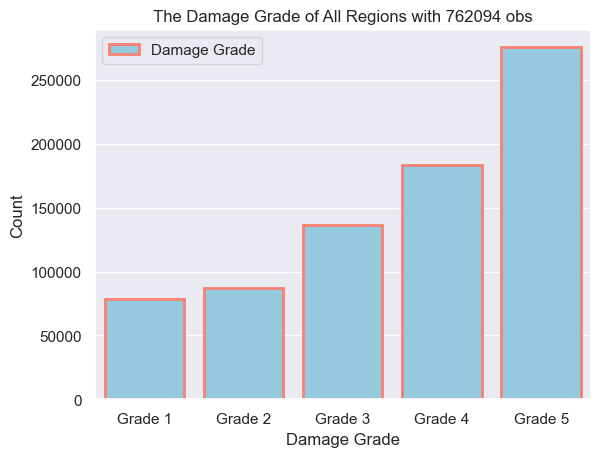

In [188]:
histogram_grade_group("All Regions",raw_structure_data)

In [189]:
# 数据可视化：Damage Grade的分地区分布
#制图
def group_plot_distribution_of_a_column(structure_data,group_colname="district_name",plot_colname="damage_grade",color="skyblue",edgecolor="salmon"):

    grouped = structure_data.groupby(group_colname)

    # 获取不同的 'district_name' 值
    group_names = list(grouped.groups.keys())

    # 计算要创建的子图的行数和列数
    num_rows = (len(group_names) + 3) // 4  # 每行有四个子图

    # 计算整体图形的大小
    fig_width = 12  
    fig_height = fig_width * (1 / 6) * num_rows*1.4

    # 创建子图
    fig, axes = plt.subplots(num_rows, 4, figsize=(fig_width, fig_height), sharey=True)
    axes = axes.flatten()  # 将二维数组展平

    xlabel=convert_string(plot_colname)
    # 对每个分组绘制 'damage_grade' 子图
    for i, (name, group) in enumerate(grouped):
        ax = axes[i]
        group[plot_colname].value_counts().sort_index().plot(kind='bar', ax=ax, alpha=0.7,color=color, edgecolor=edgecolor)
        
        # 设置每个子图的标题和标签
        ax.set_title(f'{name} with {group.shape[0]} obs')
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Count')

    # 隐藏多余的子图，如果 'group_names' 的数量不是4的倍数
    for i in range(len(group_names), num_rows * 4):
        axes[i].axis('off')

    # 调整布局
    plt.tight_layout()
    plt.show()
    print(group_names)


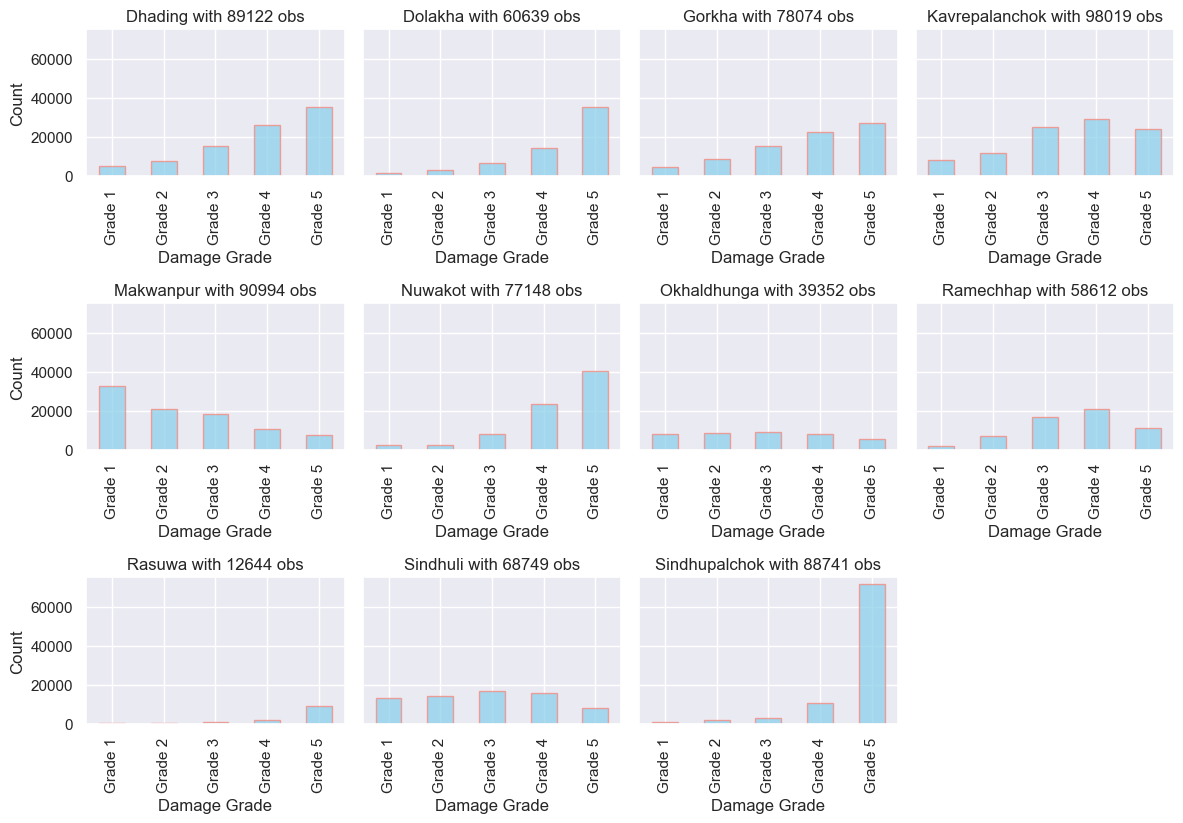

['Dhading', 'Dolakha', 'Gorkha', 'Kavrepalanchok', 'Makwanpur', 'Nuwakot', 'Okhaldhunga', 'Ramechhap', 'Rasuwa', 'Sindhuli', 'Sindhupalchok']


In [190]:
group_plot_distribution_of_a_column(structure_data)

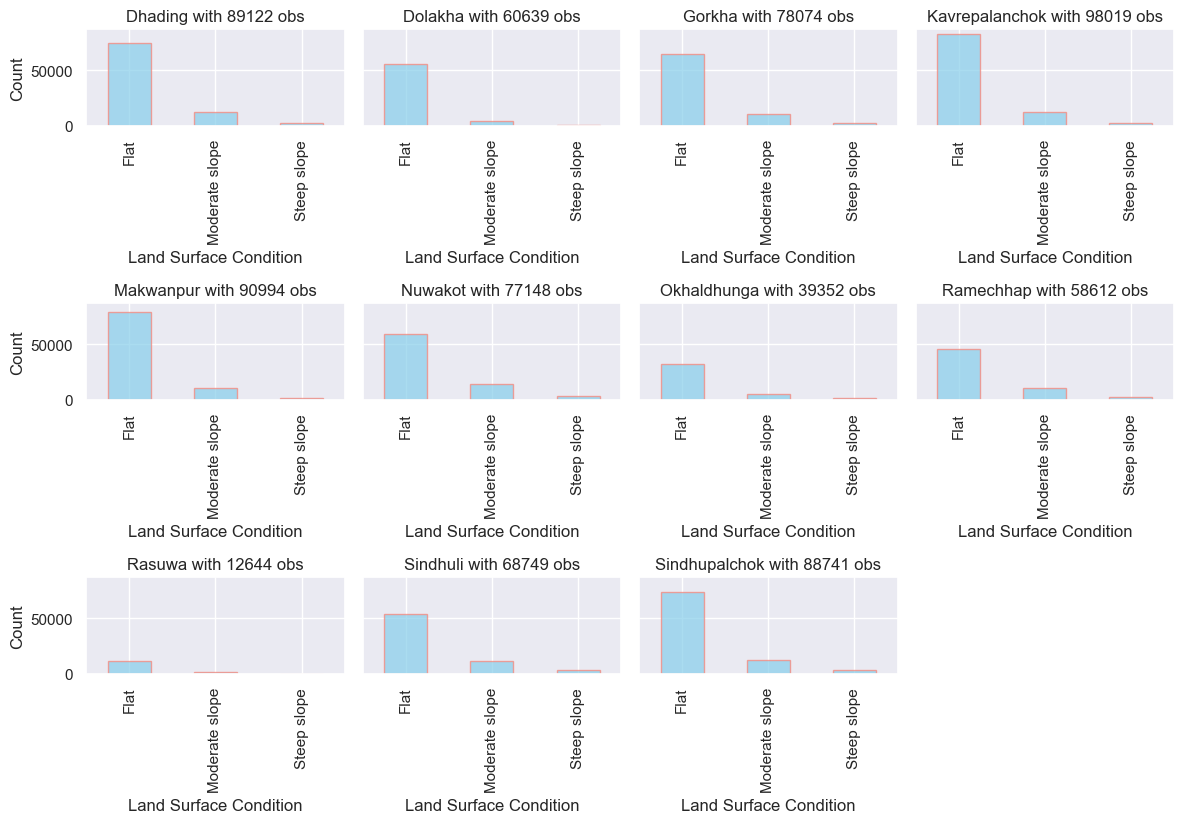

['Dhading', 'Dolakha', 'Gorkha', 'Kavrepalanchok', 'Makwanpur', 'Nuwakot', 'Okhaldhunga', 'Ramechhap', 'Rasuwa', 'Sindhuli', 'Sindhupalchok']


In [191]:
group_plot_distribution_of_a_column(structure_data,plot_colname='land_surface_condition')

object


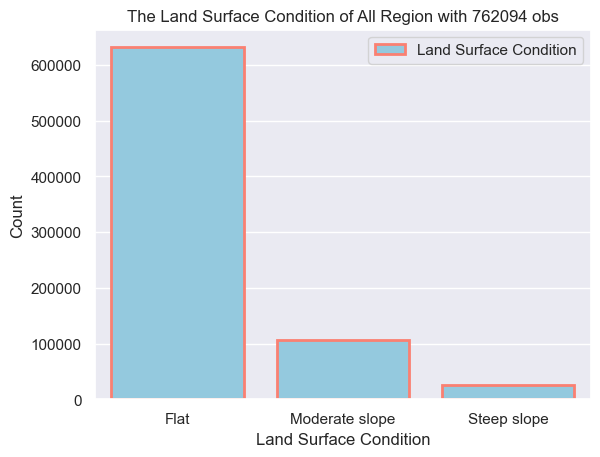

In [192]:
histogram_grade_group("All Region",structure_data,"land_surface_condition")

In [220]:
def plot_two_columns(structure_data,colname1='land_surface_condition',colname2='damage_grade',show_values=False,rotation=0):
    # Calculate counts
    df_temp = structure_data.groupby([colname1,colname2 ]).size().reset_index(name='count')

    # Calculate Proportion of grade
    df_temp['proportion'] = df_temp.groupby(colname1)['count'].transform(lambda x: 100 * x / x.sum())

    # Plot chart
    plt.figure(figsize=(12, 5))
    ax = sns.barplot(data=df_temp, 
                    x=colname1, 
                    y='proportion', 
                    hue=colname2)
    if show_values:
        show_values(ax)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    plt.title(f"Distribution of {convert_string(colname2)} by {convert_string(colname1)}")
    plt.xlabel(convert_string(colname1))
    plt.ylabel("Percentage of Buildings")
    plt.xticks(rotation=rotation)
    plt.savefig(f"{colname1} vs {colname2}.png")
    plt.show()
    print(structure_data[colname1].value_counts())
    print(ax.xaxis)

    # Clean up
    del df_temp, ax

C:\Users\hp\AppData\Local\Temp\ipykernel_6856\3608139869.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = structure_data.groupby([colname1,colname2 ]).size().reset_index(name='count')


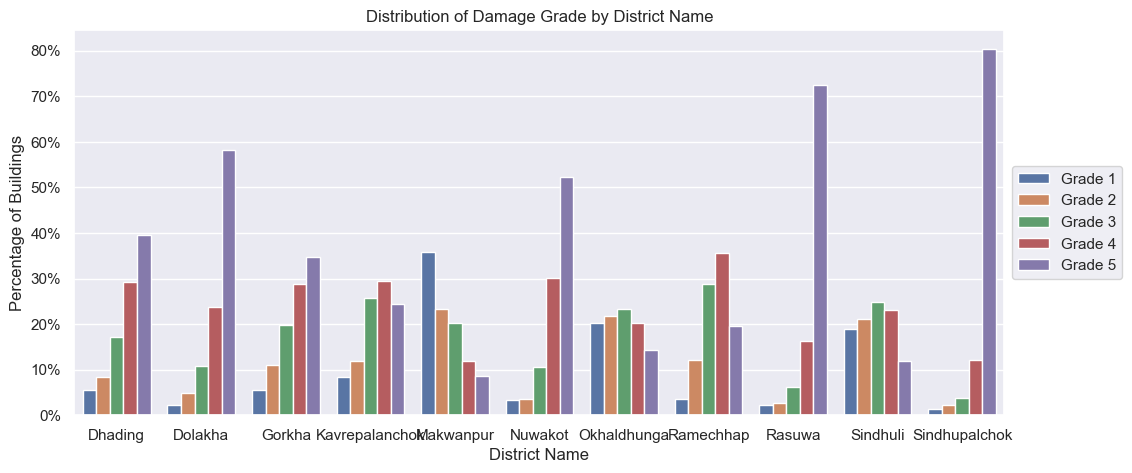

district_name
Kavrepalanchok    98019
Makwanpur         90994
Dhading           89122
Sindhupalchok     88741
Gorkha            78074
Nuwakot           77148
Sindhuli          68749
Dolakha           60639
Ramechhap         58612
Okhaldhunga       39352
Rasuwa            12644
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


In [194]:
plot_two_columns(structure_data,colname1="district_name")

C:\Users\hp\AppData\Local\Temp\ipykernel_6856\3608139869.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = structure_data.groupby([colname1,colname2 ]).size().reset_index(name='count')


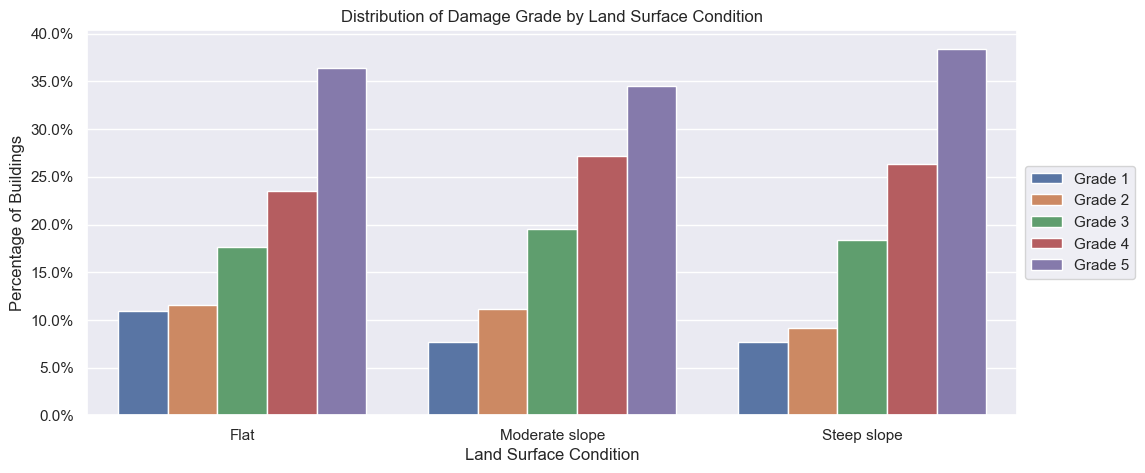

land_surface_condition
Flat              631663
Moderate slope    105640
Steep slope        24791
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


In [195]:
plot_two_columns(structure_data,colname1='land_surface_condition',colname2='damage_grade')

C:\Users\hp\AppData\Local\Temp\ipykernel_6856\3608139869.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = structure_data.groupby([colname1,colname2 ]).size().reset_index(name='count')


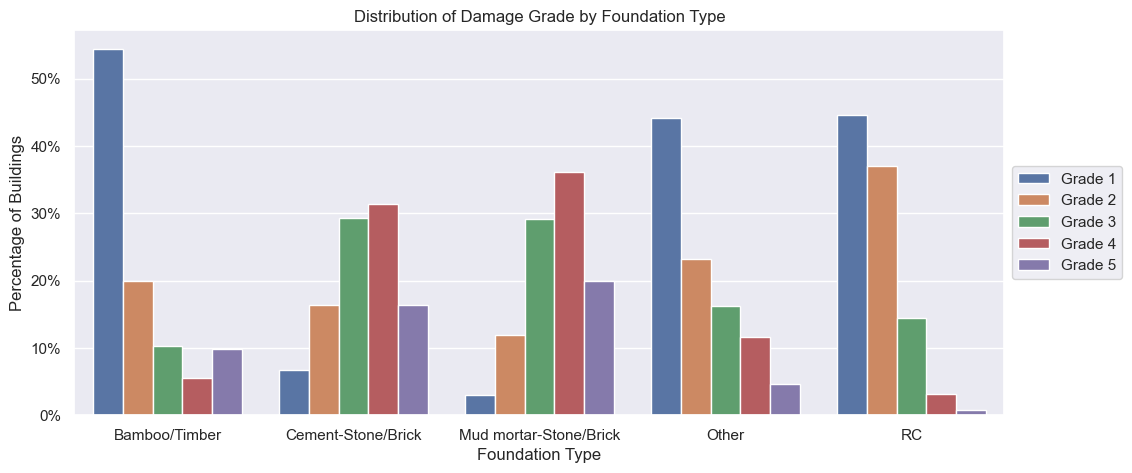

foundation_type
Mud mortar-Stone/Brick    56715
Cement-Stone/Brick         1141
RC                          478
Bamboo/Timber               235
Other                        43
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


In [196]:
plot_two_columns(structure_data[structure_data['district_id']==21],colname1="foundation_type",colname2="damage_grade")

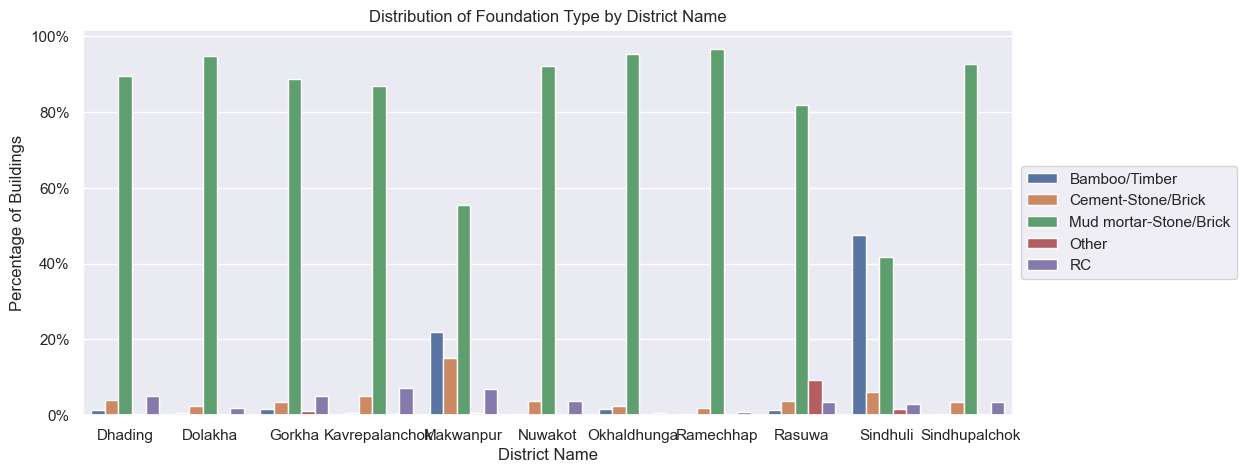

district_name
Kavrepalanchok    98019
Makwanpur         90994
Dhading           89122
Sindhupalchok     88741
Gorkha            78074
Nuwakot           77148
Sindhuli          68749
Dolakha           60639
Ramechhap         58612
Okhaldhunga       39352
Rasuwa            12644
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


In [197]:
plot_two_columns(structure_data,colname1="district_name",colname2="foundation_type")

In [198]:
# plot_two_columns(structure_data,colname1='condition_post_eq',colname2="damage_grade")

In [199]:
# plot_two_columns(structure_data,colname1="damage_grade",colname2='condition_post_eq')


In [200]:
# plot_two_columns(structure_data,colname1="condition_post_eq",colname2="damage_grade")

In [201]:
def my_violinplot(structure_data,x='damage_grade',y='age_building',ylim_low=None,ylim_high=None):
    plt.figure()
    sns.violinplot(x=x, y=y, data = structure_data,inner_kws=dict(box_width=15, whis_width=2, color=".8"))
    plt.xlabel(convert_string(x))
    plt.ylabel(convert_string(y))
    plt.title("The distribution of {} v.s. {}".format(convert_string(y),convert_string(x)))
    plt.ylim(ylim_low,ylim_high)
    plt.savefig(f"{y} vs {x}.png")
    plt.show()

d:\Anacoda\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


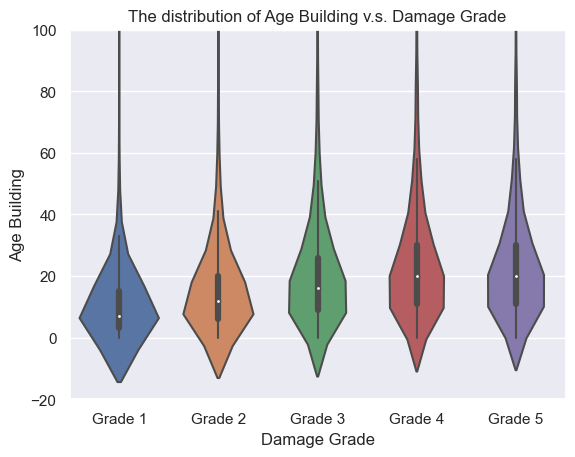

In [202]:
my_violinplot(structure_data,y="age_building",ylim_low=-20,ylim_high=100)

d:\Anacoda\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


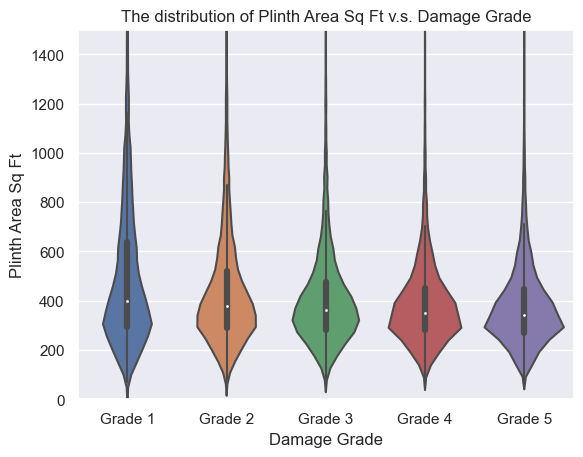

In [203]:
#count_floors_pre_eq
my_violinplot(structure_data,y="plinth_area_sq_ft",ylim_low=0,ylim_high=1500)

d:\Anacoda\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


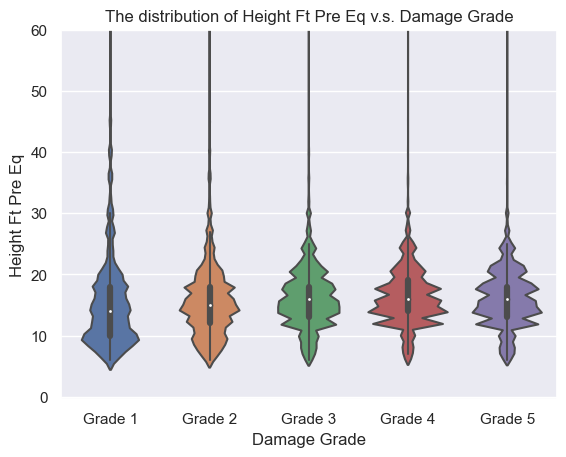

In [204]:
my_violinplot(structure_data,y='height_ft_pre_eq',ylim_high=60)

C:\Users\hp\AppData\Local\Temp\ipykernel_6856\3608139869.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = structure_data.groupby([colname1,colname2 ]).size().reset_index(name='count')


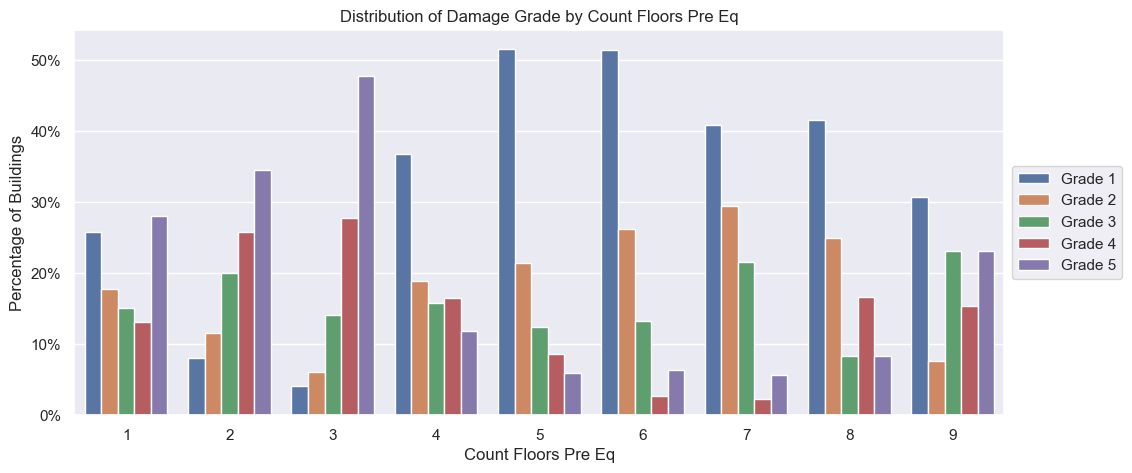

count_floors_pre_eq
2    468103
3    166993
1    118899
4      6085
5      1569
6       332
7        88
9        13
8        12
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


In [205]:
plot_two_columns(structure_data,colname1='count_floors_pre_eq')

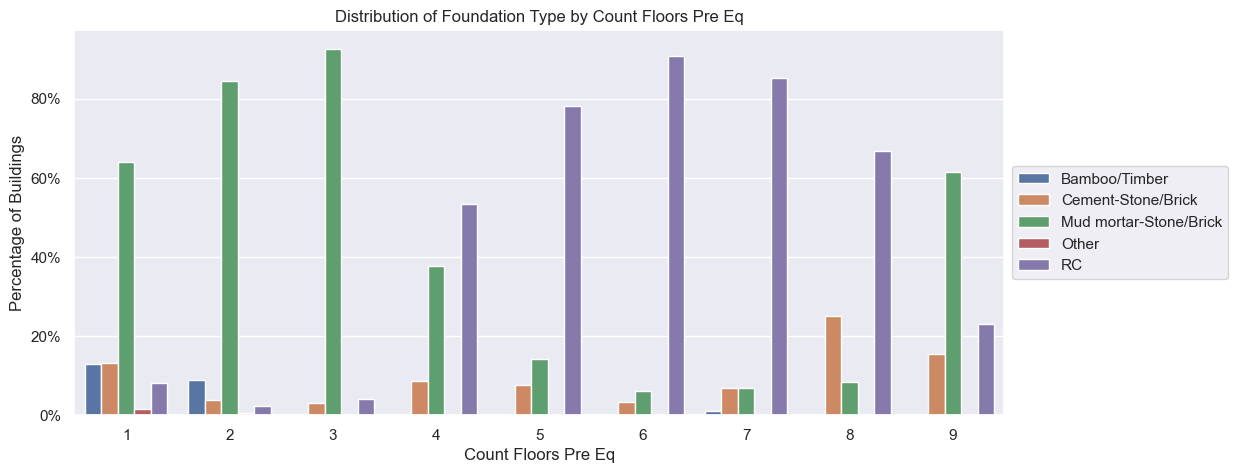

count_floors_pre_eq
2    468103
3    166993
1    118899
4      6085
5      1569
6       332
7        88
9        13
8        12
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


In [206]:
plot_two_columns(structure_data,colname1='count_floors_pre_eq',colname2="foundation_type")

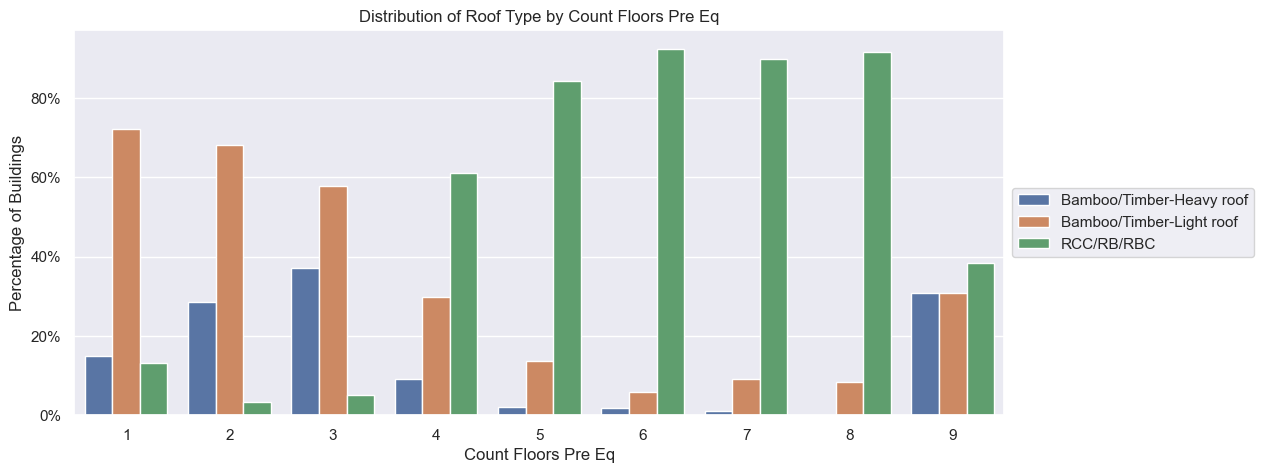

count_floors_pre_eq
2    468103
3    166993
1    118899
4      6085
5      1569
6       332
7        88
9        13
8        12
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


In [207]:
plot_two_columns(structure_data,colname1='count_floors_pre_eq',colname2="roof_type")

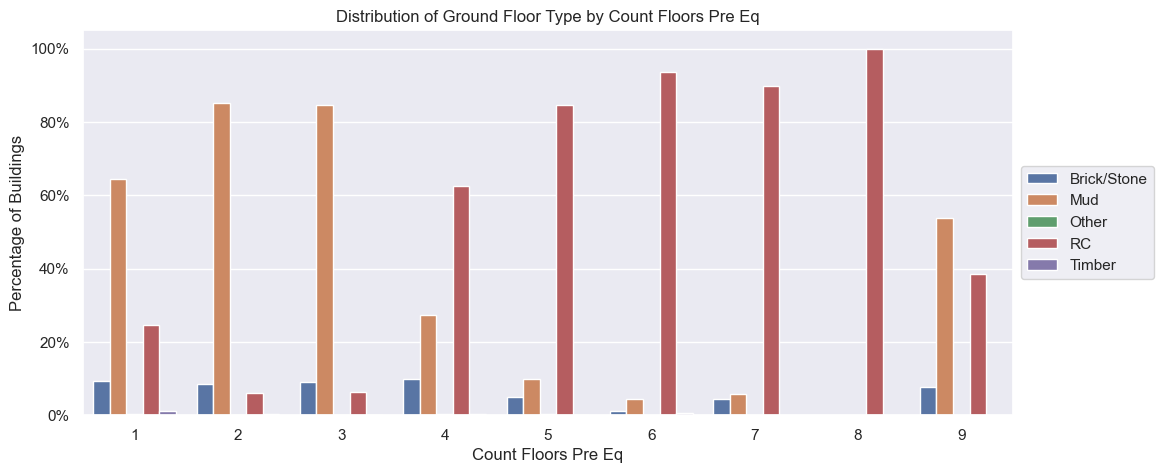

count_floors_pre_eq
2    468103
3    166993
1    118899
4      6085
5      1569
6       332
7        88
9        13
8        12
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


In [208]:
plot_two_columns(structure_data,colname1='count_floors_pre_eq',colname2="ground_floor_type")

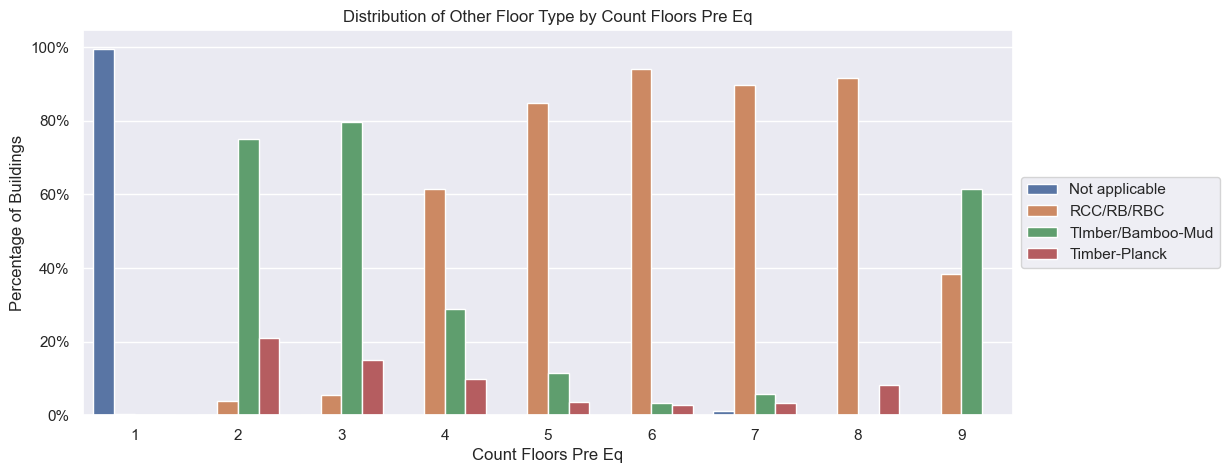

count_floors_pre_eq
2    468103
3    166993
1    118899
4      6085
5      1569
6       332
7        88
9        13
8        12
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


In [209]:
plot_two_columns(structure_data,colname1='count_floors_pre_eq',colname2='other_floor_type')

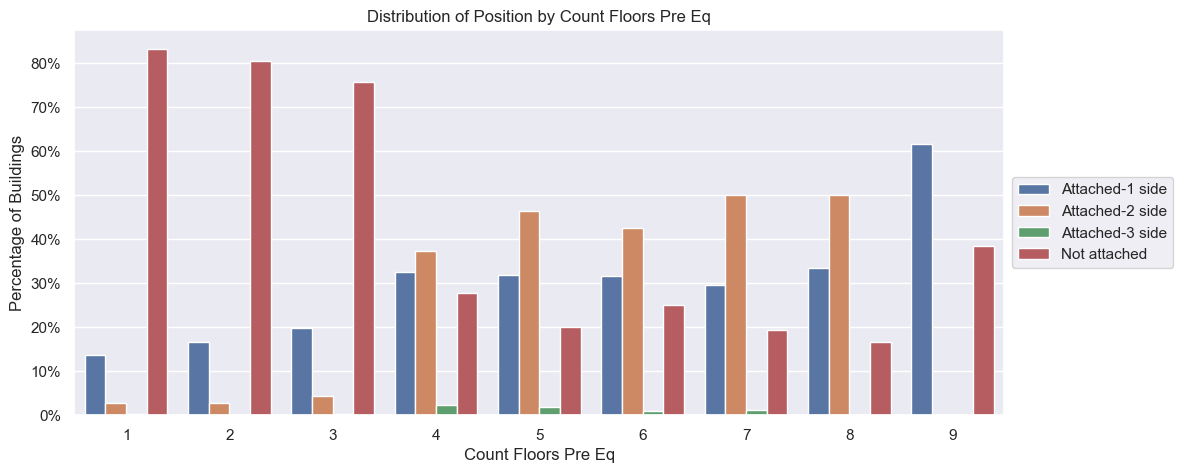

count_floors_pre_eq
2    468103
3    166993
1    118899
4      6085
5      1569
6       332
7        88
9        13
8        12
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


In [210]:
plot_two_columns(structure_data,colname1='count_floors_pre_eq',colname2='position')

C:\Users\hp\AppData\Local\Temp\ipykernel_6856\3608139869.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = structure_data.groupby([colname1,colname2 ]).size().reset_index(name='count')


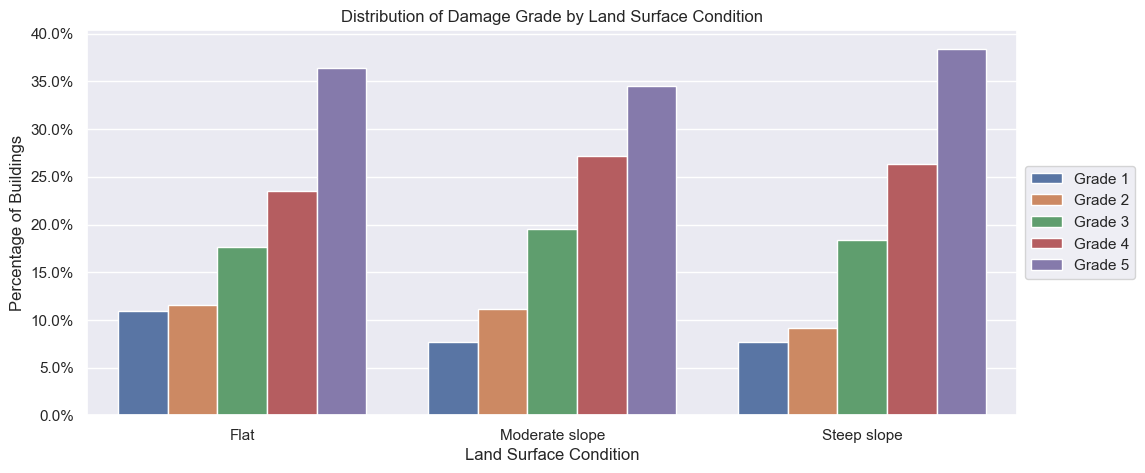

land_surface_condition
Flat              631663
Moderate slope    105640
Steep slope        24791
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


In [211]:
plot_two_columns(structure_data,colname1="land_surface_condition")

C:\Users\hp\AppData\Local\Temp\ipykernel_6856\3608139869.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = structure_data.groupby([colname1,colname2 ]).size().reset_index(name='count')


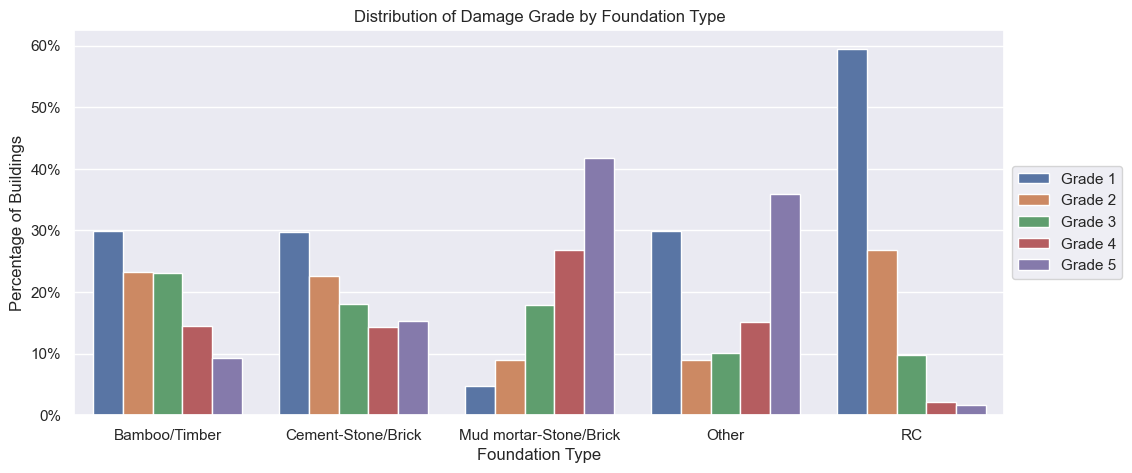

foundation_type
Mud mortar-Stone/Brick    628705
Bamboo/Timber              57472
Cement-Stone/Brick         39245
RC                         32120
Other                       4552
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


In [212]:
plot_two_columns(structure_data,colname1="foundation_type")

C:\Users\hp\AppData\Local\Temp\ipykernel_6856\3608139869.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = structure_data.groupby([colname1,colname2 ]).size().reset_index(name='count')


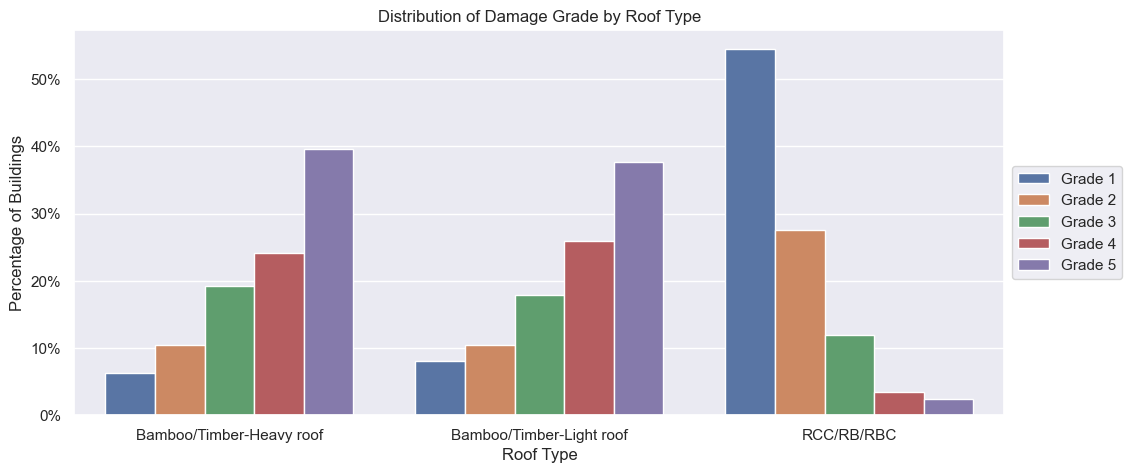

roof_type
Bamboo/Timber-Light roof    503736
Bamboo/Timber-Heavy roof    213774
RCC/RB/RBC                   44584
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


In [213]:
plot_two_columns(structure_data,"roof_type")

In [224]:
44584/750000

0.059445333333333336

C:\Users\hp\AppData\Local\Temp\ipykernel_6856\3608139869.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = structure_data.groupby([colname1,colname2 ]).size().reset_index(name='count')


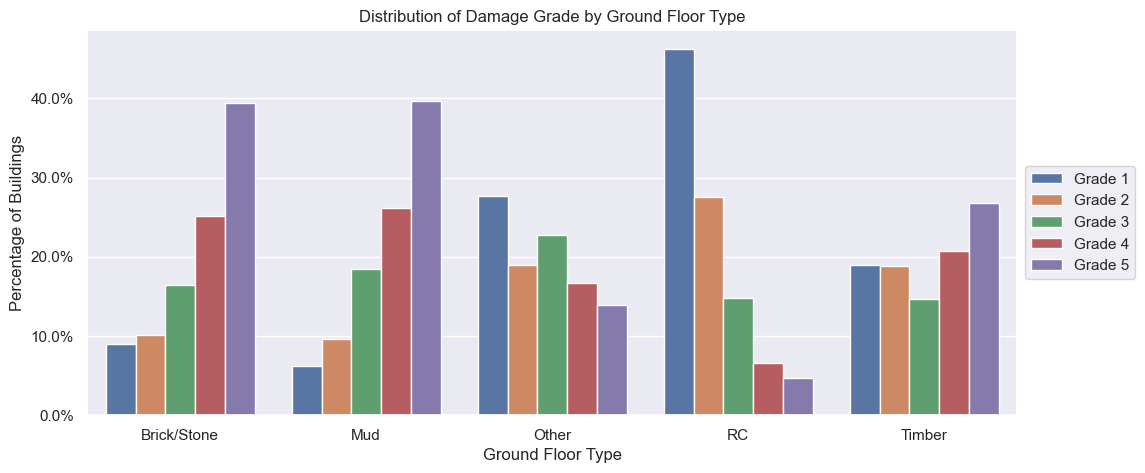

ground_floor_type
Mud            618205
RC              73149
Brick/Stone     66093
Timber           3594
Other            1053
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


In [214]:
plot_two_columns(structure_data,"ground_floor_type")

In [215]:
structure_data.columns

Index(['district_id', 'count_floors_pre_eq', 'age_building',
       'plinth_area_sq_ft', 'height_ft_pre_eq', 'land_surface_condition',
       'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type',
       'position', 'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'damage_grade', 'vdcmun_name', 'district_name'],
      dtype='object')

C:\Users\hp\AppData\Local\Temp\ipykernel_6856\3608139869.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = structure_data.groupby([colname1,colname2 ]).size().reset_index(name='count')


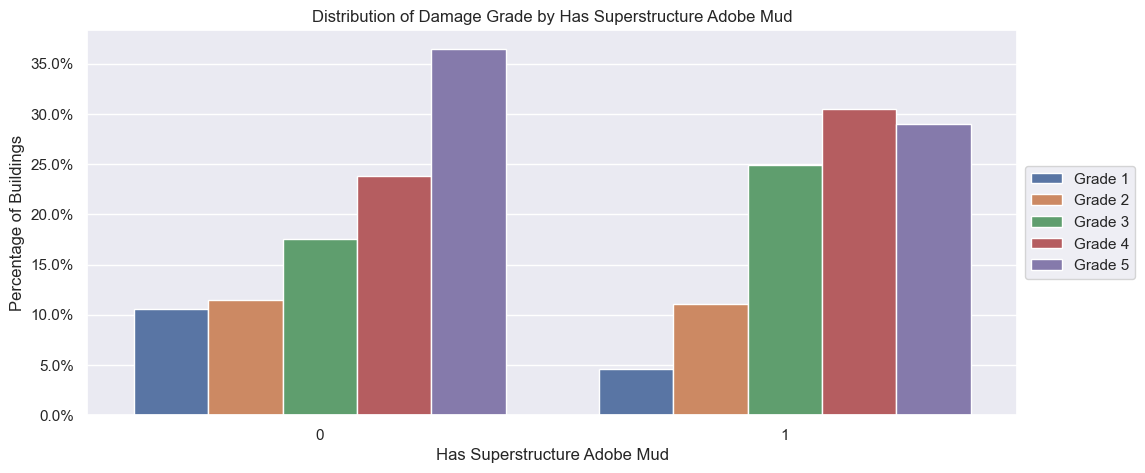

has_superstructure_adobe_mud
0    729780
1     32314
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


C:\Users\hp\AppData\Local\Temp\ipykernel_6856\3608139869.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = structure_data.groupby([colname1,colname2 ]).size().reset_index(name='count')


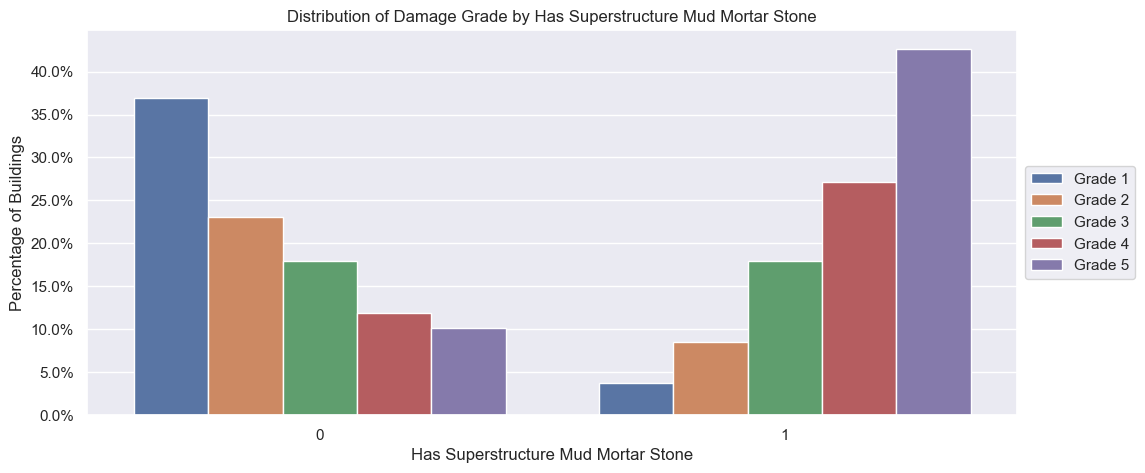

has_superstructure_mud_mortar_stone
1    609880
0    152214
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


C:\Users\hp\AppData\Local\Temp\ipykernel_6856\3608139869.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = structure_data.groupby([colname1,colname2 ]).size().reset_index(name='count')


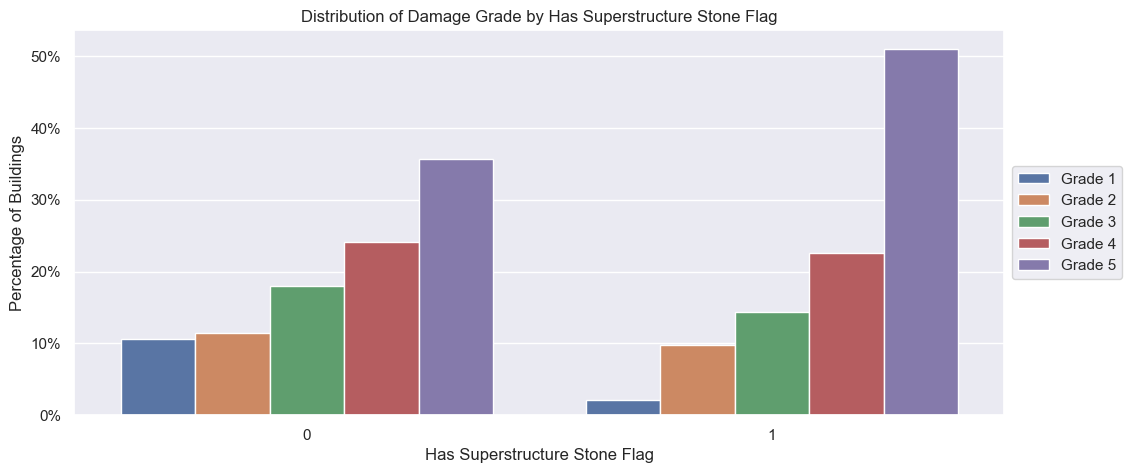

has_superstructure_stone_flag
0    735328
1     26766
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


C:\Users\hp\AppData\Local\Temp\ipykernel_6856\3608139869.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = structure_data.groupby([colname1,colname2 ]).size().reset_index(name='count')


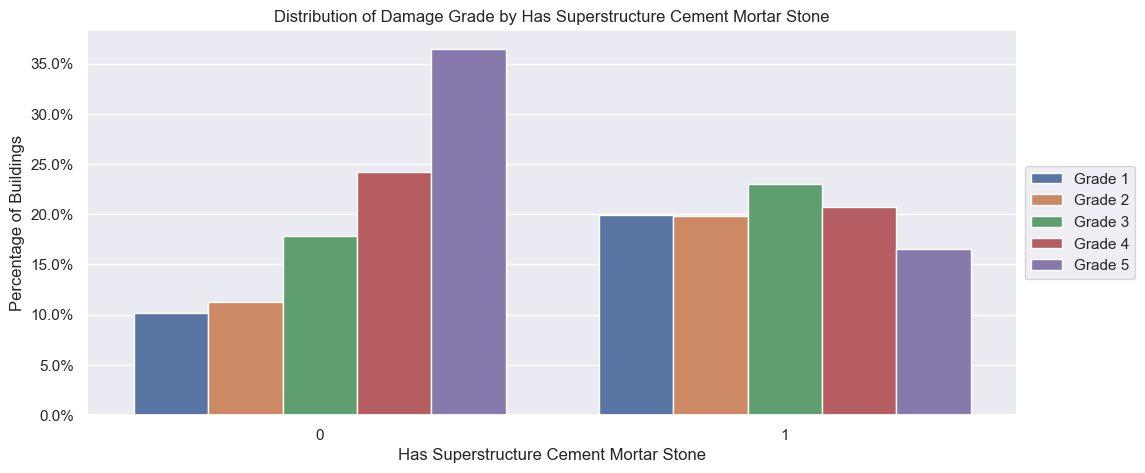

has_superstructure_cement_mortar_stone
0    750041
1     12053
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


C:\Users\hp\AppData\Local\Temp\ipykernel_6856\3608139869.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = structure_data.groupby([colname1,colname2 ]).size().reset_index(name='count')


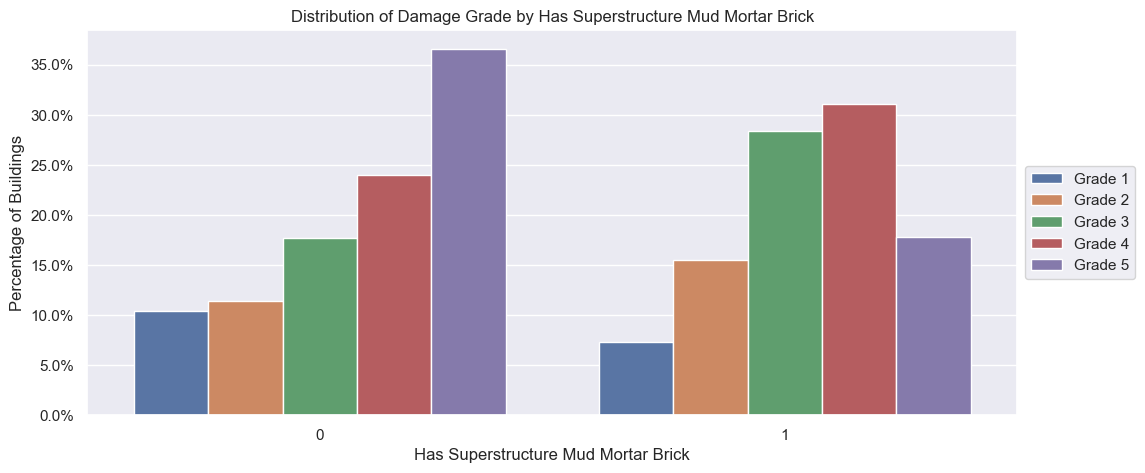

has_superstructure_mud_mortar_brick
0    744595
1     17499
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


C:\Users\hp\AppData\Local\Temp\ipykernel_6856\3608139869.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = structure_data.groupby([colname1,colname2 ]).size().reset_index(name='count')


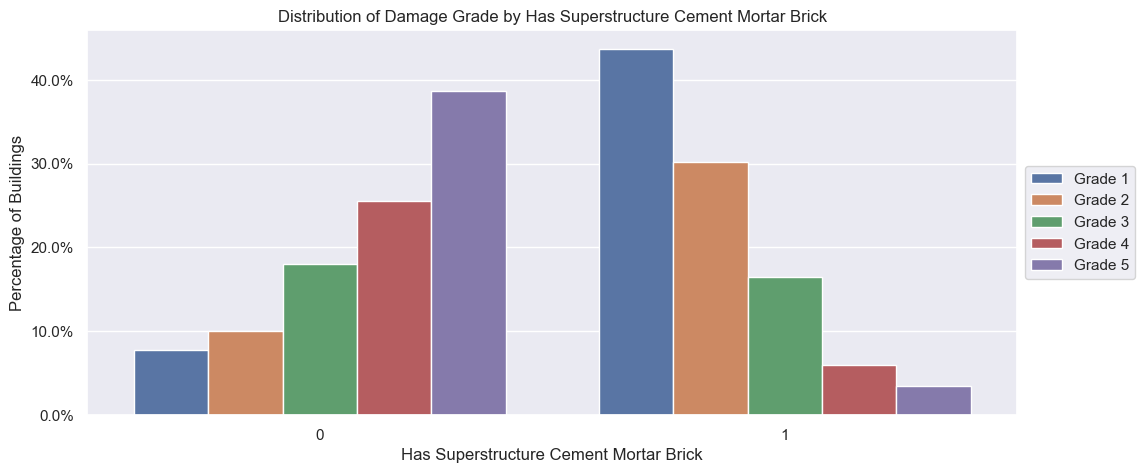

has_superstructure_cement_mortar_brick
0    707584
1     54510
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


C:\Users\hp\AppData\Local\Temp\ipykernel_6856\3608139869.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = structure_data.groupby([colname1,colname2 ]).size().reset_index(name='count')


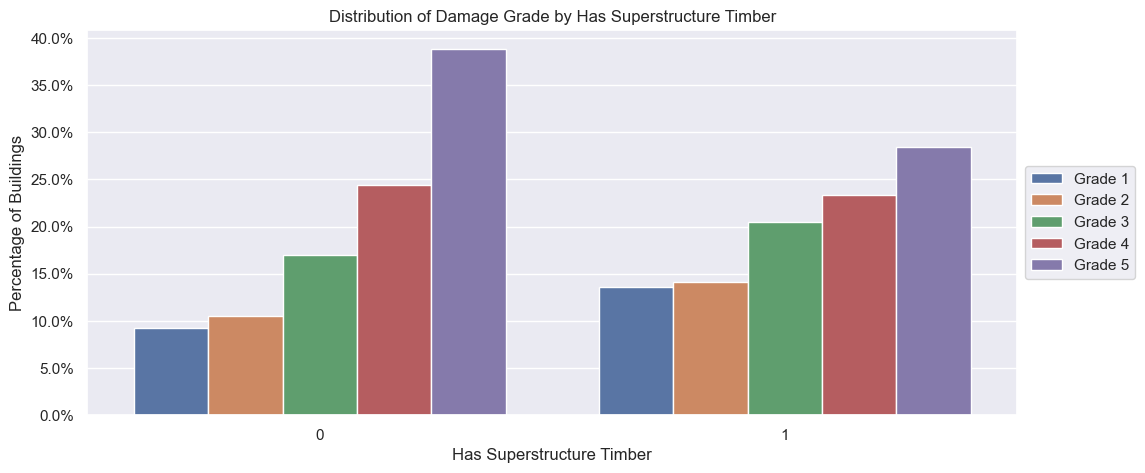

has_superstructure_timber
0    564887
1    197207
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


C:\Users\hp\AppData\Local\Temp\ipykernel_6856\3608139869.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = structure_data.groupby([colname1,colname2 ]).size().reset_index(name='count')


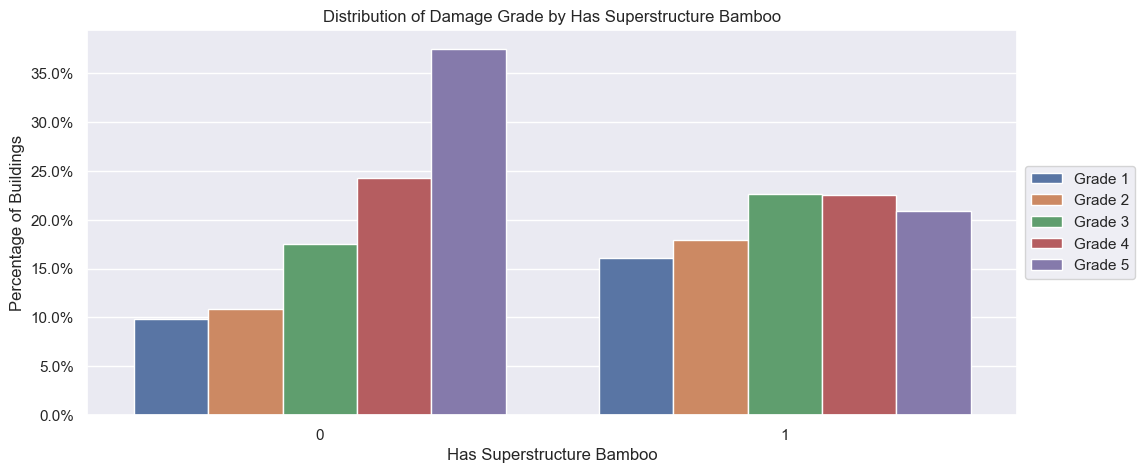

has_superstructure_bamboo
0    700758
1     61336
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


C:\Users\hp\AppData\Local\Temp\ipykernel_6856\3608139869.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = structure_data.groupby([colname1,colname2 ]).size().reset_index(name='count')


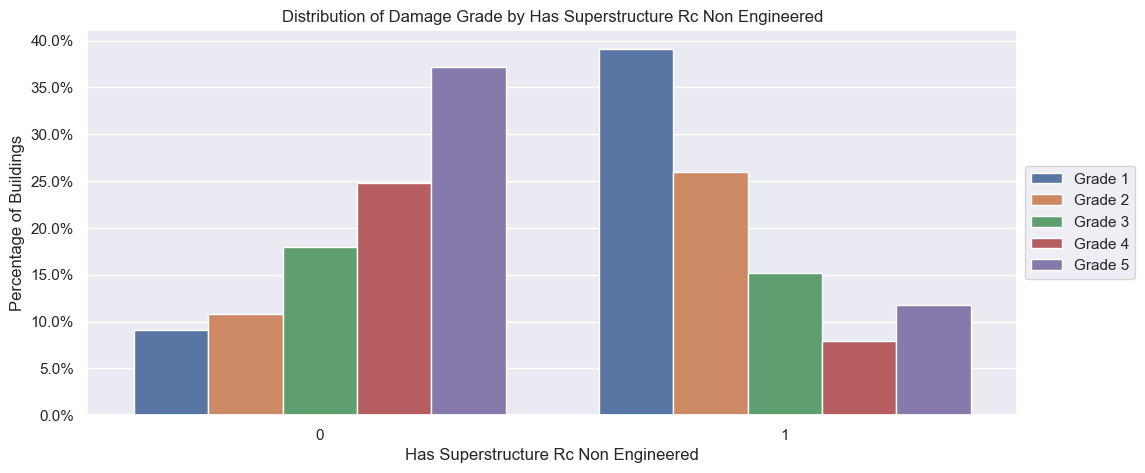

has_superstructure_rc_non_engineered
0    731767
1     30327
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


C:\Users\hp\AppData\Local\Temp\ipykernel_6856\3608139869.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = structure_data.groupby([colname1,colname2 ]).size().reset_index(name='count')


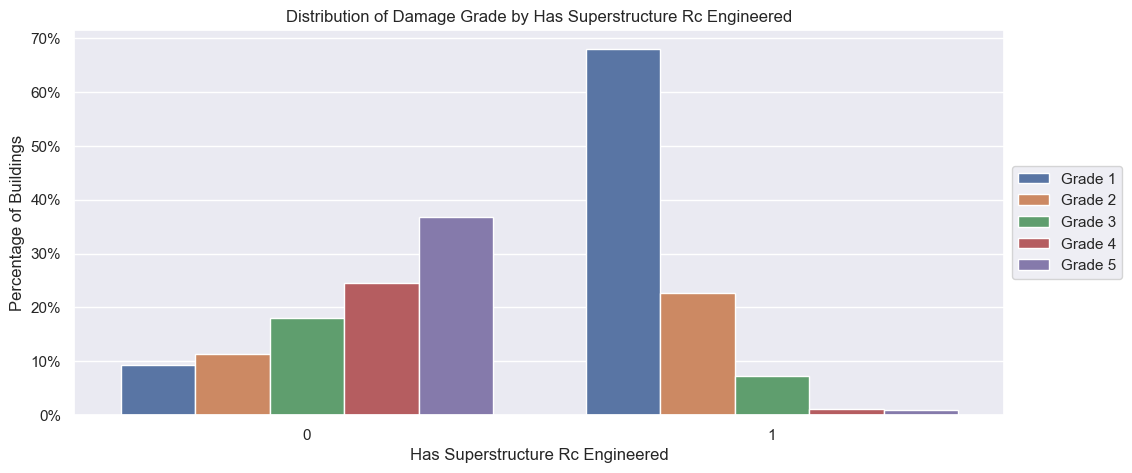

has_superstructure_rc_engineered
0    749606
1     12488
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


C:\Users\hp\AppData\Local\Temp\ipykernel_6856\3608139869.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = structure_data.groupby([colname1,colname2 ]).size().reset_index(name='count')


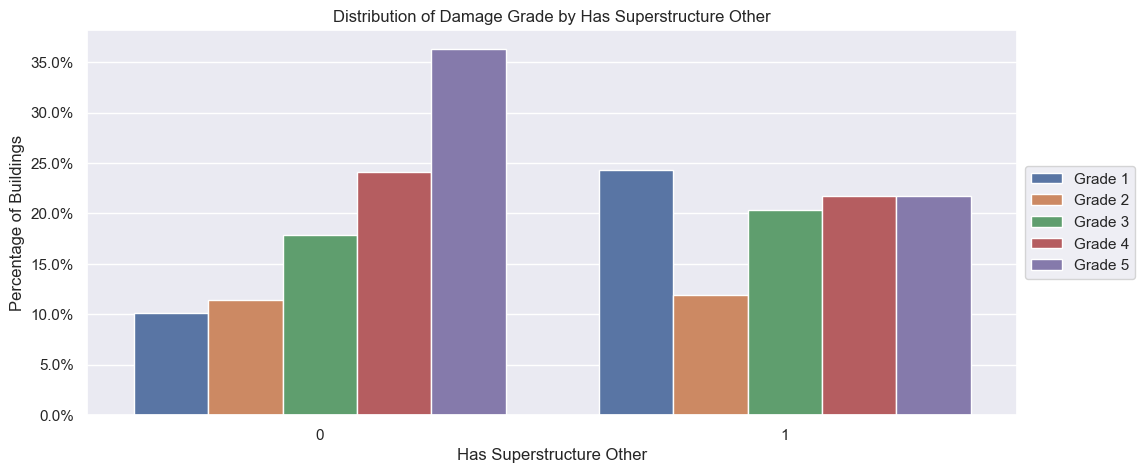

has_superstructure_other
0    752929
1      9165
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


In [216]:
for col in [x for x in structure_data.columns if x.startswith("has")]:
    plot_two_columns(structure_data,col)

C:\Users\hp\AppData\Local\Temp\ipykernel_6856\3608139869.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = structure_data.groupby([colname1,colname2 ]).size().reset_index(name='count')


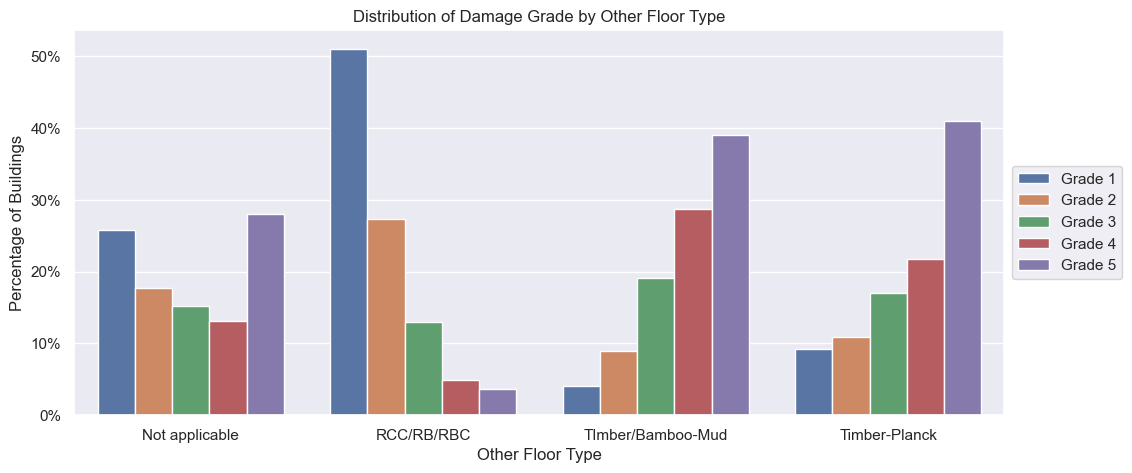

other_floor_type
TImber/Bamboo-Mud    486907
Timber-Planck        123624
Not applicable       118821
RCC/RB/RBC            32742
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


In [217]:
plot_two_columns(structure_data,"other_floor_type")

C:\Users\hp\AppData\Local\Temp\ipykernel_6856\3608139869.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = structure_data.groupby([colname1,colname2 ]).size().reset_index(name='count')


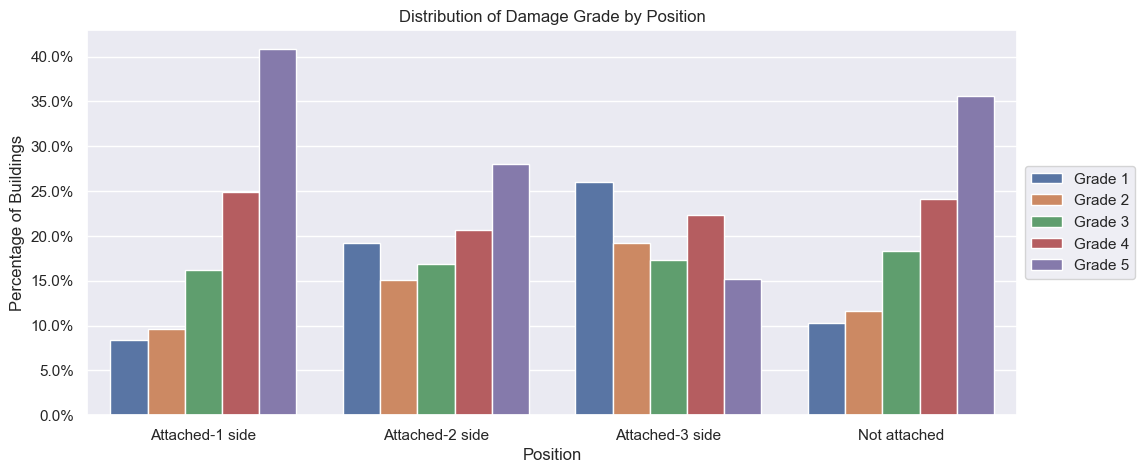

position
Not attached       604443
Attached-1 side    129431
Attached-2 side     26910
Attached-3 side      1310
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


In [218]:
plot_two_columns(structure_data,"position")

C:\Users\hp\AppData\Local\Temp\ipykernel_6856\3935727144.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp = structure_data.groupby([colname1,colname2 ]).size().reset_index(name='count')


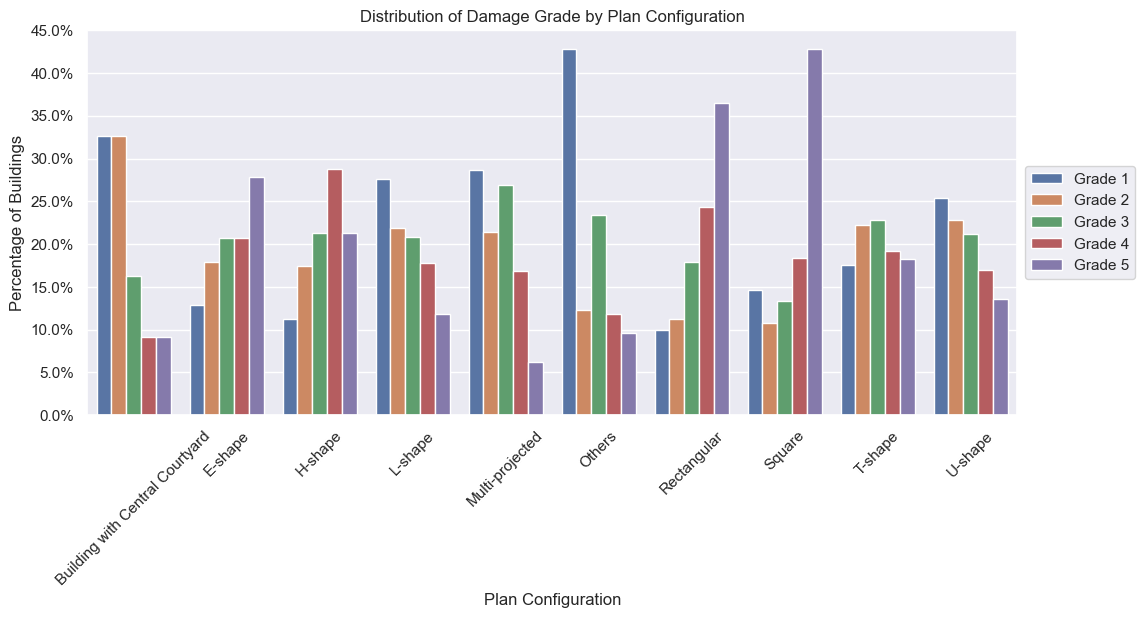

plan_configuration
Rectangular                        731246
Square                              17576
L-shape                             10079
T-shape                               969
Multi-projected                       940
Others                                518
U-shape                               448
E-shape                               140
Building with Central Courtyard        98
H-shape                                80
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


In [222]:
plot_two_columns(structure_data,"plan_configuration",rotation=45)

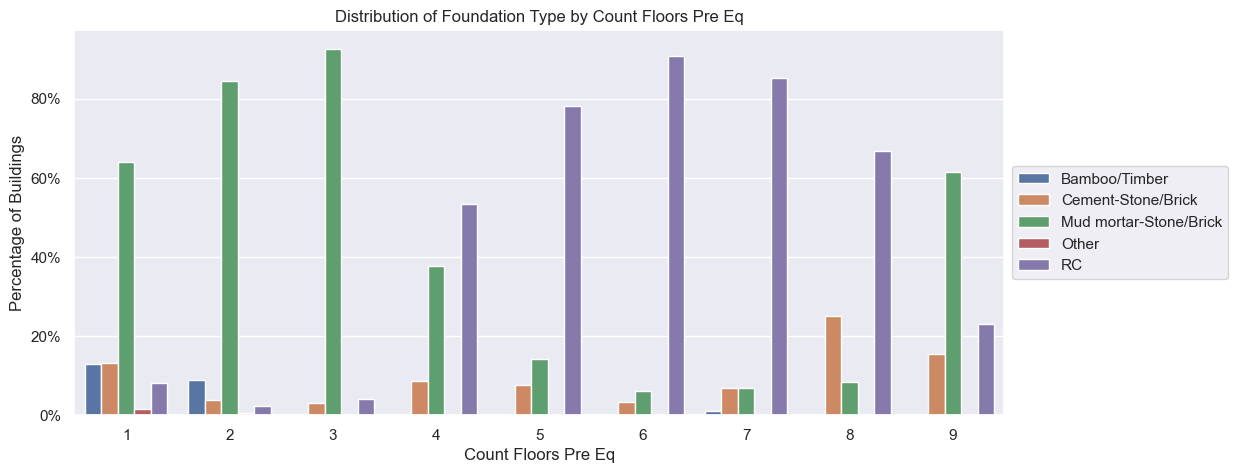

count_floors_pre_eq
2    468103
3    166993
1    118899
4      6085
5      1569
6       332
7        88
9        13
8        12
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


In [223]:
plot_two_columns(structure_data,"count_floors_pre_eq","foundation_type")

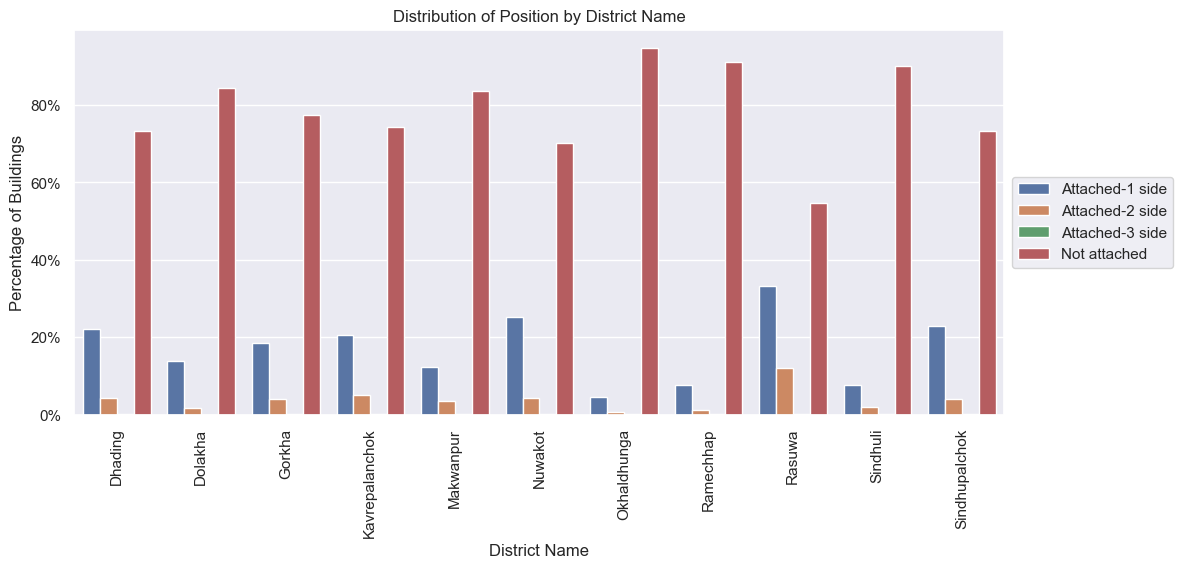

district_name
Kavrepalanchok    98019
Makwanpur         90994
Dhading           89122
Sindhupalchok     88741
Gorkha            78074
Nuwakot           77148
Sindhuli          68749
Dolakha           60639
Ramechhap         58612
Okhaldhunga       39352
Rasuwa            12644
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


In [227]:
plot_two_columns(structure_data,"district_name","position",rotation=90)

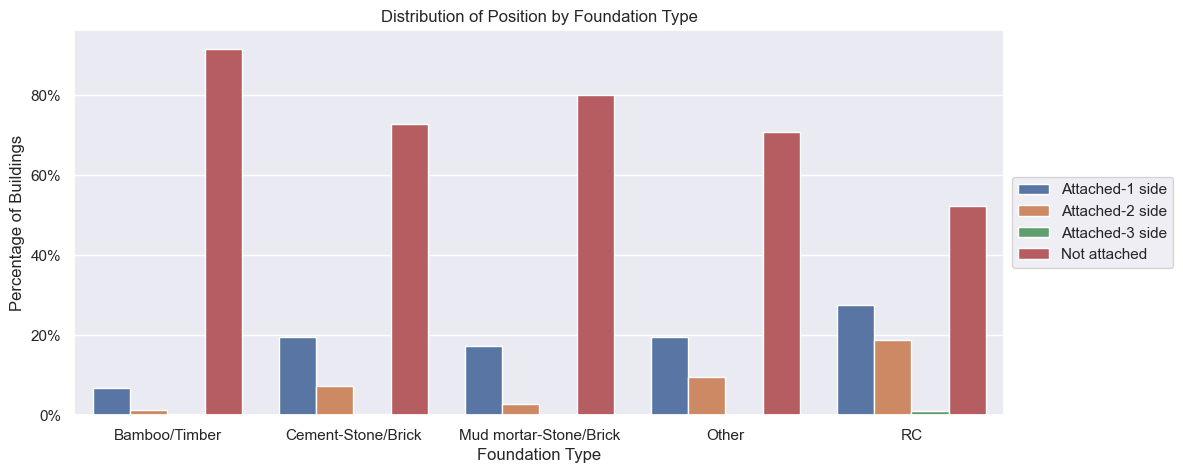

foundation_type
Mud mortar-Stone/Brick    628705
Bamboo/Timber              57472
Cement-Stone/Brick         39245
RC                         32120
Other                       4552
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


In [229]:
plot_two_columns(structure_data,"foundation_type","position",rotation=None)

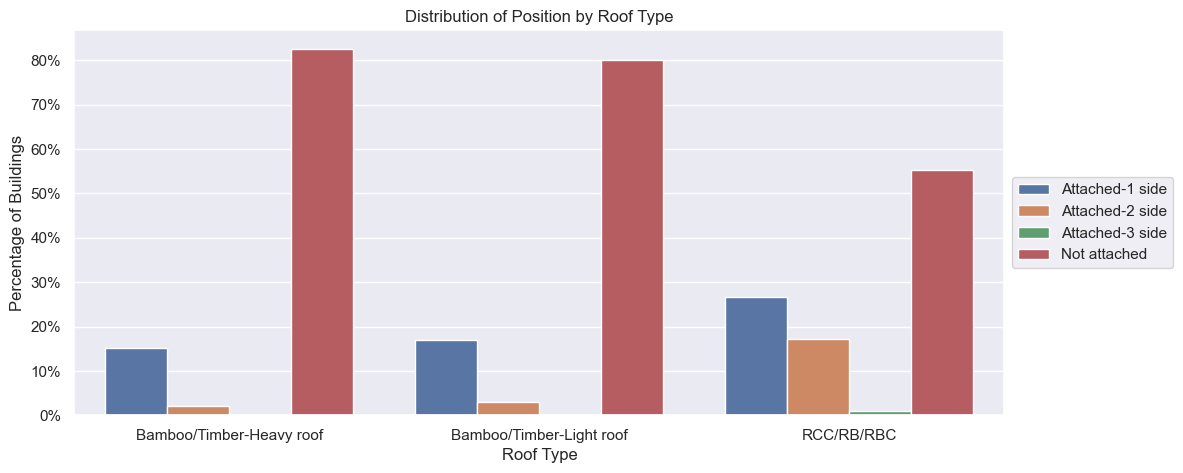

roof_type
Bamboo/Timber-Light roof    503736
Bamboo/Timber-Heavy roof    213774
RCC/RB/RBC                   44584
Name: count, dtype: int64
XAxis(150.0,54.99999999999999)


In [230]:
plot_two_columns(structure_data,"roof_type","position",rotation=None)